In [1]:
import pandas as pd
import numpy as np
import re
import string
import missingno as msno
import nltk
from textblob import TextBlob

nltk.download('punkt')
nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('maxent_ne_chunker')
# nltk.download('words')
from nltk.corpus import stopwords

import snowballstemmer

stemmer = snowballstemmer.stemmer('english')

nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import matplotlib.pyplot as plt
# import plotly.express as px
import seaborn as sns

from wordcloud import WordCloud



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Daniel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Daniel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Daniel\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Data Preparation and Sentiment Analysis

# EDA

In [2]:
# data = pd.read_csv('data/www.porkbun.com - Trustpilot.csv', encoding='utf-8')
data = pd.read_csv('data/all.csv', encoding='utf-8')
data.head()


,Unnamed: 0.1,Unnamed: 0,site,date,stars,title,text,location
0,0,0,nordvpn.com,2023-01-14T07:13:59.000Z,1,Had 5G speed plummet from 400mbps down…,With just one device connected 4G+ speed 90mbp...,GB
1,1,1,nordvpn.com,2023-01-12T18:22:21.000Z,1,Very Slow,Very Slow - avoid this company Recently signed...,CA
2,2,2,nordvpn.com,2023-01-11T19:04:20.000Z,2,Underwhelming service and functionality,I have been using the service for about 3 mont...,DK
3,3,3,nordvpn.com,2023-01-11T21:11:06.000Z,1,I can't wait to switch VPNs,I can't wait to switch VPNs. Every time my PC ...,CA
4,4,4,nordvpn.com,2023-01-10T20:23:31.000Z,1,Horrible,Horrible. Beware!! I signed up and after m...,US


In [3]:
data.shape

(46746, 8)

In [4]:
data.nunique()

Unnamed: 0.1    46746
Unnamed: 0       7440
site               11
date            46722
stars               5
title           42350
text            44911
location          188
dtype: int64

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46746 entries, 0 to 46745
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0.1  46746 non-null  int64 
 1   Unnamed: 0    46746 non-null  int64 
 2   site          46746 non-null  object
 3   date          46746 non-null  object
 4   stars         46746 non-null  int64 
 5   title         46746 non-null  object
 6   text          46746 non-null  object
 7   location      46740 non-null  object
dtypes: int64(3), object(5)
memory usage: 2.9+ MB


<AxesSubplot: >

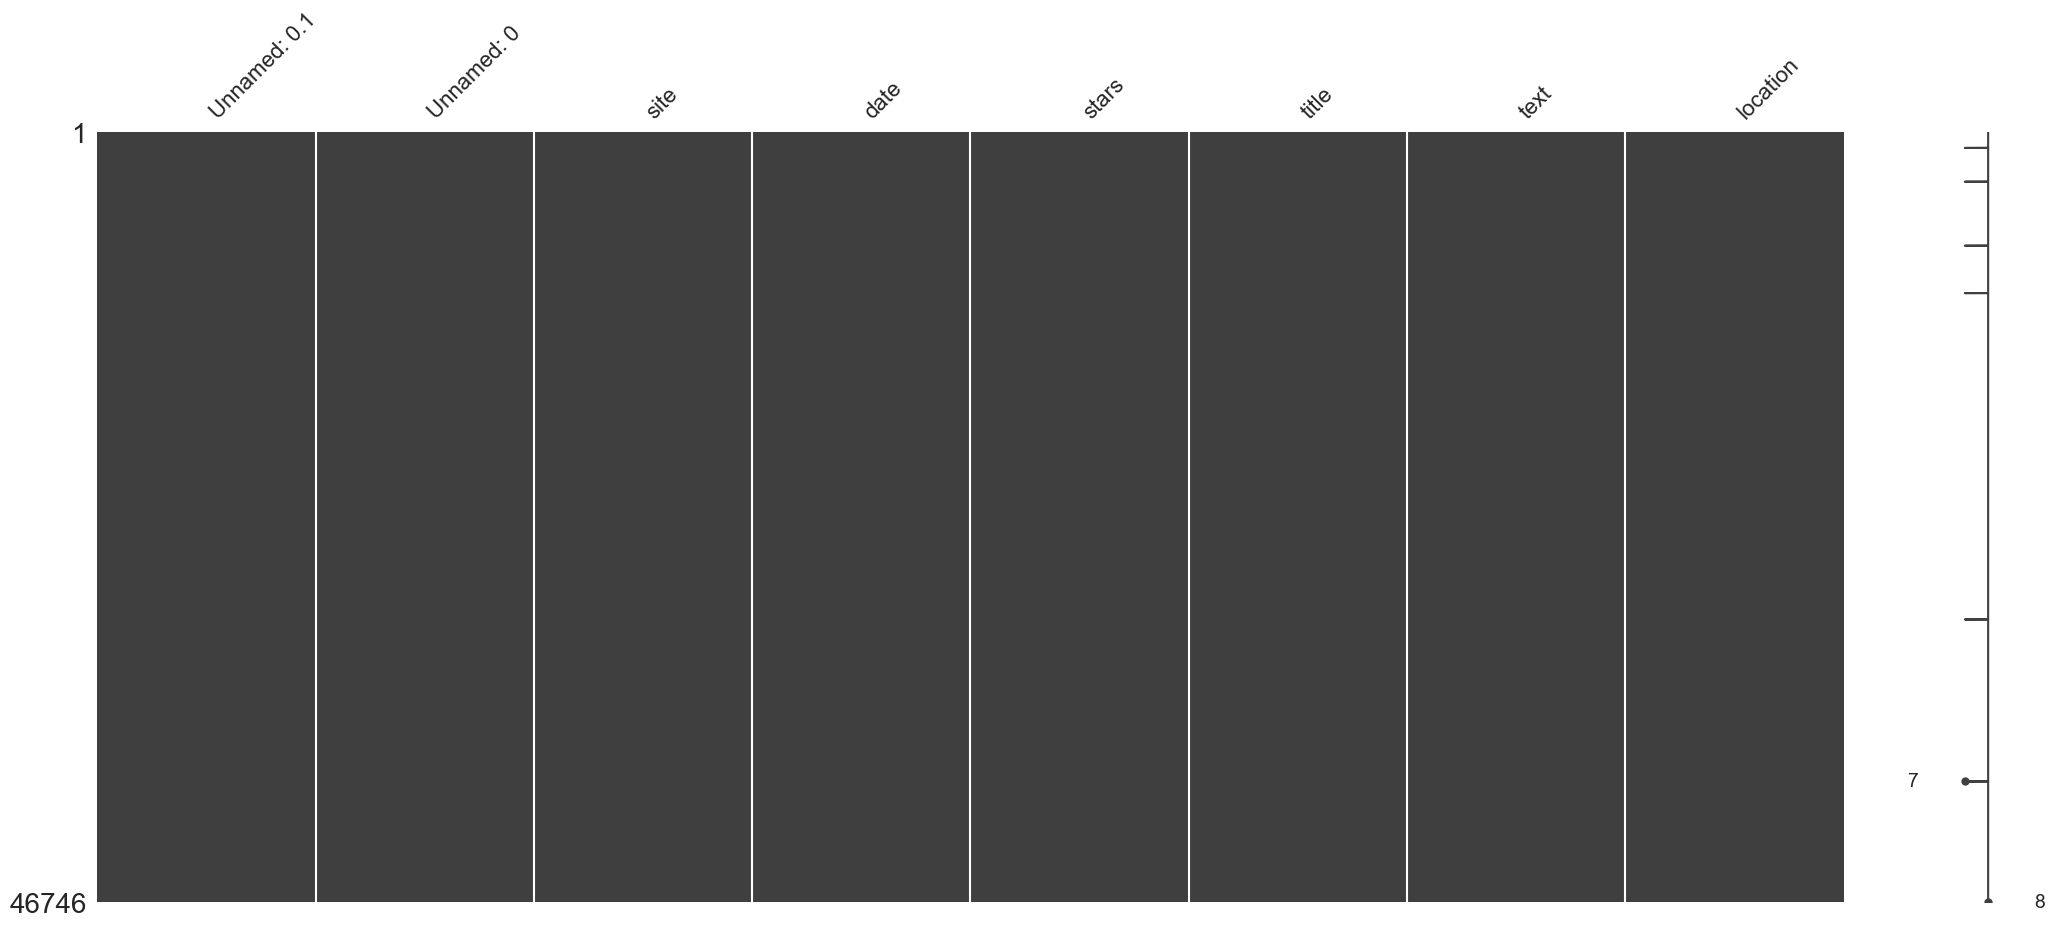

In [6]:
msno.matrix(data)

In [7]:
data.drop(['Unnamed: 0', 'date', 'location'], inplace=True, axis=1)
data.head()

,Unnamed: 0.1,site,stars,title,text
0,0,nordvpn.com,1,Had 5G speed plummet from 400mbps down…,With just one device connected 4G+ speed 90mbp...
1,1,nordvpn.com,1,Very Slow,Very Slow - avoid this company Recently signed...
2,2,nordvpn.com,2,Underwhelming service and functionality,I have been using the service for about 3 mont...
3,3,nordvpn.com,1,I can't wait to switch VPNs,I can't wait to switch VPNs. Every time my PC ...
4,4,nordvpn.com,1,Horrible,Horrible. Beware!! I signed up and after m...


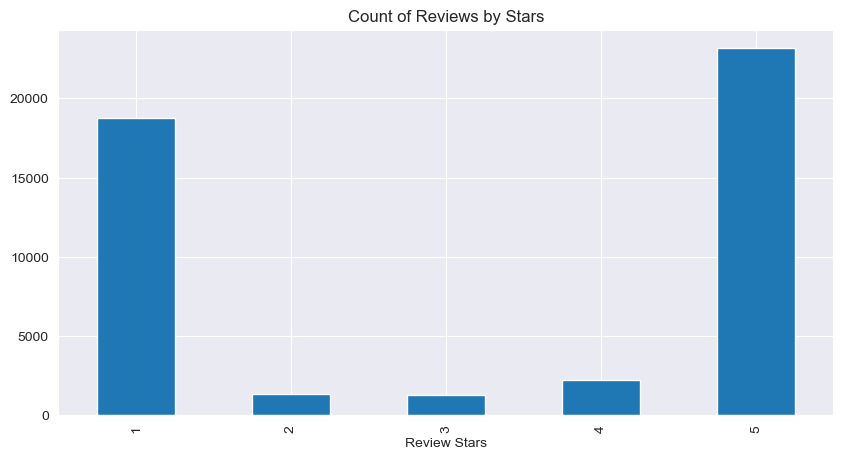

In [8]:
ax = data['stars'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

## Cleaning

In [9]:
stp_words = stopwords.words('english')


def clean_text(text):
    # No data
    if text.startswith('Date of experience:'):
        return np.nan

    text = text.lower()

    text = re.sub('\\\\', ' ', text)  # removal of escaped escape

    # replace single quotes
    text = re.sub(r"\[\'", '["', text)
    text = re.sub(r"\']", '"]', text)

    text = re.sub(r"(\', )", '", ', text)
    text = re.sub(r"(, \')", ', "', text)

    #  remove links
    text = re.sub(r"https?:\/\/[a-zA-Z0-9,.\/?#:\-_.~&]*", ' ', text)

    # remove emojis | source: https://stackoverflow.com/a/49146722
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    # remove stopwords, numbers and punctuation
    text = ' '.join(word.strip(string.punctuation) for word in text.split() if
                    (word not in stp_words) or (not any(c.isdigit() for c in word)))

    text = re.sub(r'\s+', ' ', text)  #removal of multiple spaces

    # stem text
    text = " ".join(stemmer.stemWords(text.split()))

    # tokens = nltk.word_tokenize(text)
    # tagged = nltk.pos_tag(tokens)
    # entities = nltk.chunk.ne_chunk(tagged)

    if len(text) == 0:
        return np.nan

    return text

In [10]:
# data['title_clean'] = data['title'].apply(clean_text)
data['text_clean'] = data['text'].apply(clean_text)

In [11]:
# print(data["title_clean"].isna().sum())
print(data["text_clean"].isna().sum())

2751


In [12]:
# drop empty columns after preprocessing
data.dropna(inplace=True)
data.shape

(43995, 6)

In [13]:
# print(data["title_clean"].isna().sum())
print(data["text_clean"].isna().sum())

0


### Rating - sentiment analysis mapping
- 1 -> -1 - -.75
- 2 -> -.75 - .-25
- 3 -> -.25 - .25
- 4 -> .25 - .75
- 5 -> .75 - 1

negative: 1,2 -> -1
neutral: 0 -> 0
positiv: 4,5 -> 1

In [21]:
data.loc[data['stars'] == 1, 'sentiment'] = 'negative'
data.loc[data['stars'] == 5, 'sentiment'] = 'positive'
data.loc[data['stars'].between(2, 4), 'sentiment'] = 'neutral'

In [22]:
data.groupby('sentiment')['sentiment'].count()

sentiment
negative    4518
neutral     4518
positive    4518
Name: sentiment, dtype: int64

In [23]:
data = data.groupby('sentiment').head(data.groupby('sentiment')['sentiment'].count().min())

In [24]:
data.shape

(13554, 7)

### WordCloud

In [25]:
def print_wordCloud(category, text):
    print(category)
    wordcloud = WordCloud(width = 400, height = 400,
                background_color ='white',
                min_font_size = 10).generate(text)
    plt.figure(figsize = (7, 7), facecolor = 'white', edgecolor='blue')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

def make_string(category):
    post_comments_str = ""
    for row_index, row in data[data['sentiment'] == category].iterrows():
        post_comments_str += " " + row['text_clean']
    return post_comments_str

negative


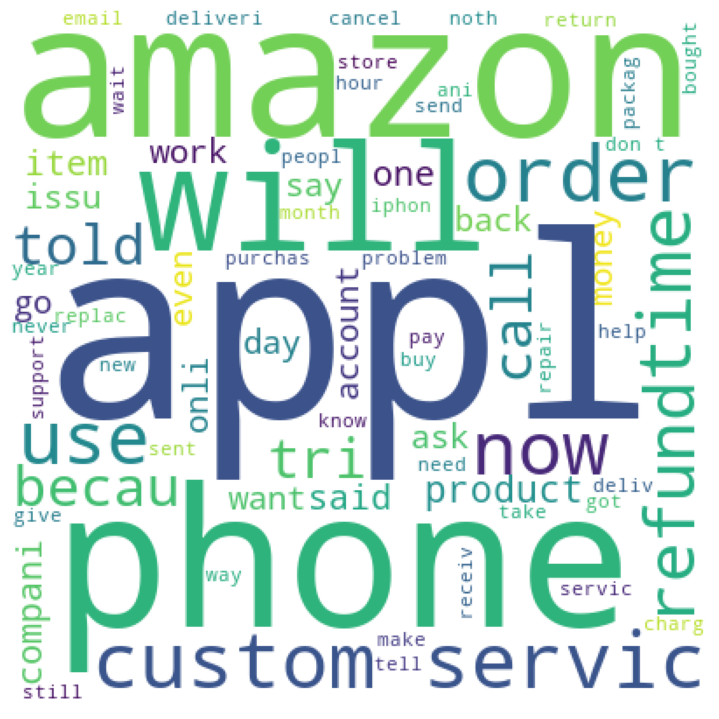

neutral


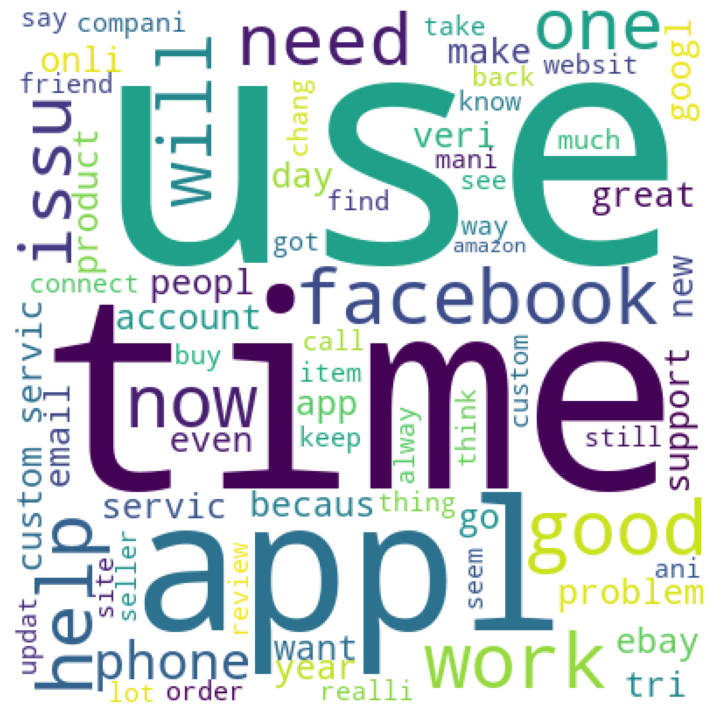

positive


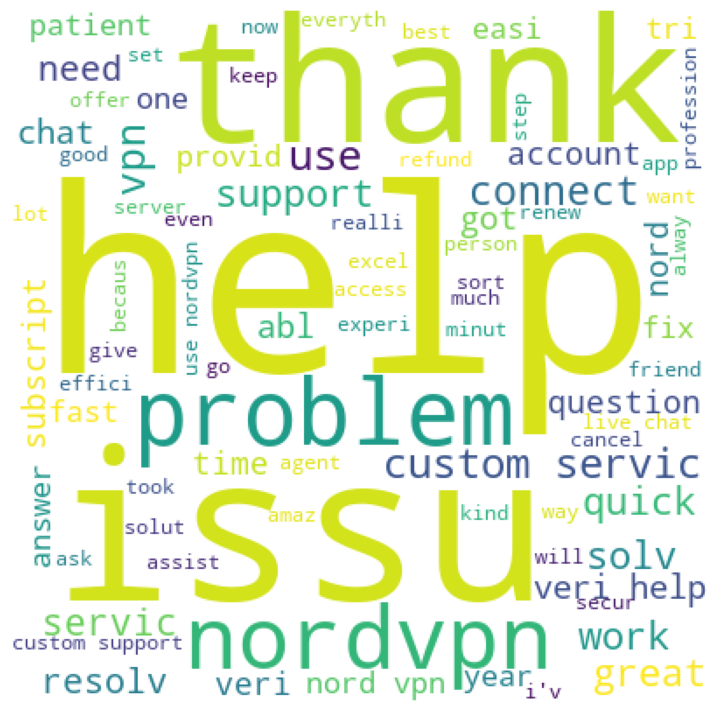

In [26]:
sentiment_list = data['sentiment'].unique().tolist()

for s in sentiment_list:
    sentiment_text = make_string(s)
    print_wordCloud(s, sentiment_text)

In [28]:
data.to_csv('data/all_cleaned')

# Sentiment Analysis

## VADER

In [29]:
sid_vader = SentimentIntensityAnalyzer()

In [30]:
# data['title_sid_vader'] = data['title_clean'].apply(lambda content: sid_vader.polarity_scores(content))
data['text_sid_vader'] = data['text_clean'].apply(lambda content: sid_vader.polarity_scores(content))

# data = pd.concat([data.drop(['title_sid_vader'], axis=1), data['title_sid_vader'].apply(pd.Series)], axis=1)
# data = pd.concat([data.drop(['text_sid_vader'], axis=1), data['text_sid_vader'].apply(lambda value:
#     pd.Series(value).rename(index={'neg': 'title_sid_vader_neg', 'neu': 'title_sid_vader_neu',
#                             'pos': 'title_sid_vader_pos',
#                             'compound': 'title_sid_vader_compound'}))], axis=1)
data = pd.concat([data.drop(['text_sid_vader'], axis=1), data['text_sid_vader']
                 .apply(lambda value: pd.Series(value).rename(index={
    'neg': 'text_sid_vader_neg',
    'neu': 'text_sid_vader_neu',
    'pos': 'text_sid_vader_pos',
    'compound': 'text_sid_vader_compound'}))],
                 axis=1)

### Plot VADER results

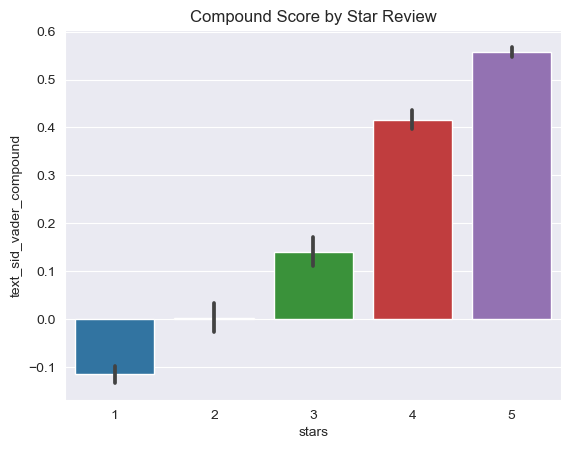

In [31]:
ax = sns.barplot(data=data, x='stars', y='text_sid_vader_compound')
ax.set_title('Compound Score by Star Review')
plt.show()

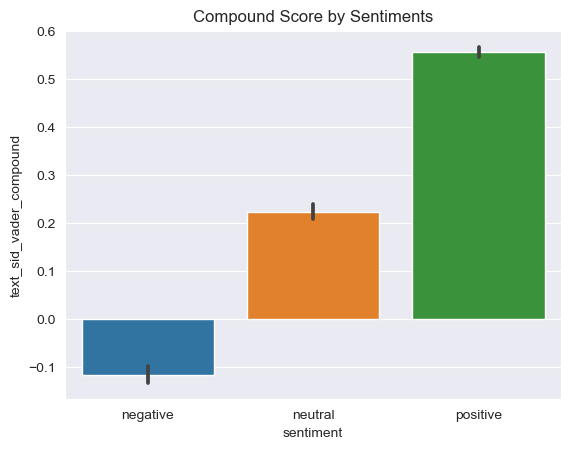

In [32]:
ax = sns.barplot(data=data, x='sentiment', y='text_sid_vader_compound')
ax.set_title('Compound Score by Sentiments')
plt.show()

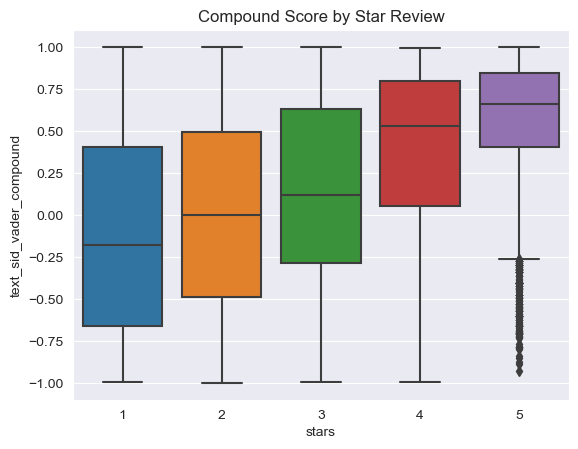

In [33]:
ax = sns.boxplot(data=data, x='stars', y='text_sid_vader_compound')
ax.set_title('Compound Score by Star Review')
plt.show()

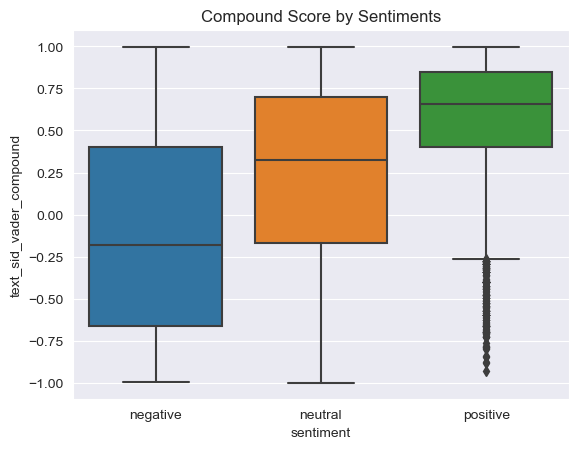

In [34]:
ax = sns.boxplot(data=data, x='sentiment', y='text_sid_vader_compound')
ax.set_title('Compound Score by Sentiments')
plt.show()

In [35]:
data.groupby('stars')['text_sid_vader_compound'].describe()
# gleichmäßige buckets - sortierte Beispiele
# median als obergrenze
# sterne auf neg neu pos aufteilen

,count,mean,std,min,25%,50%,75%,max
stars,,,,,,,,
1,4518.0,-0.116150,0.597880,-0.9937,-0.65970,-0.1779,0.401900,0.9989
2,1291.0,0.001164,0.570040,-0.9979,-0.48945,0.0000,0.493900,0.9961
3,1202.0,0.139855,0.543363,-0.9917,-0.28585,0.1217,0.631000,0.9962
4,2025.0,0.415045,0.454960,-0.9929,0.05160,0.5267,0.796400,0.9923
5,4518.0,0.557578,0.370003,-0.9287,0.40190,0.6597,0.845725,0.9966


In [36]:
data.groupby('sentiment')['text_sid_vader_compound'].describe()

,count,mean,std,min,25%,50%,75%,max
sentiment,,,,,,,,
negative,4518.0,-0.116150,0.597880,-0.9937,-0.6597,-0.1779,0.401900,0.9989
neutral,4518.0,0.223567,0.544507,-0.9979,-0.1685,0.3217,0.700825,0.9962
positive,4518.0,0.557578,0.370003,-0.9287,0.4019,0.6597,0.845725,0.9966


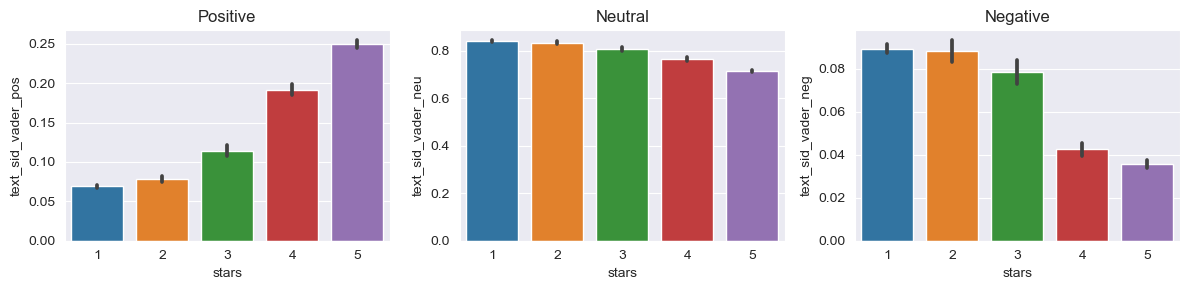

In [37]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=data, x='stars', y='text_sid_vader_pos', ax=axs[0])
sns.barplot(data=data, x='stars', y='text_sid_vader_neu', ax=axs[1])
sns.barplot(data=data, x='stars', y='text_sid_vader_neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

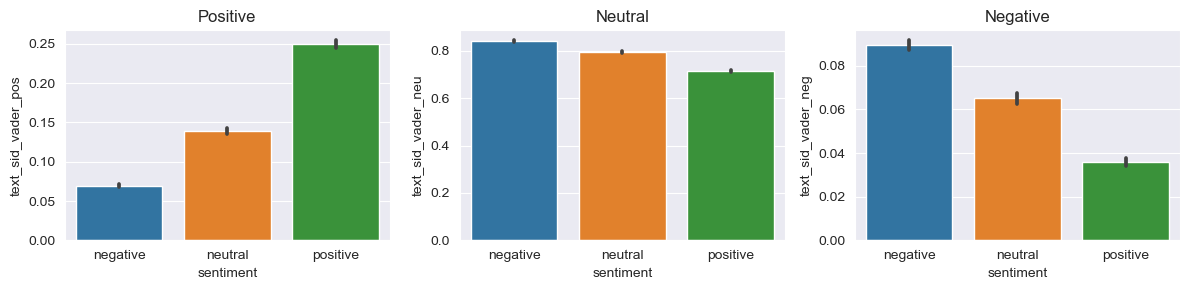

In [38]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=data, x='sentiment', y='text_sid_vader_pos', ax=axs[0])
sns.barplot(data=data, x='sentiment', y='text_sid_vader_neu', ax=axs[1])
sns.barplot(data=data, x='sentiment', y='text_sid_vader_neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

## TextBlob

In [39]:
# data['title_sid_textblob_polarity '] = data['title_clean'].apply(lambda content: TextBlob(content).sentiment.polarity)
data['text_sid_textblob_polarity'] = data['text_clean'].apply(lambda content: TextBlob(content).sentiment.polarity)


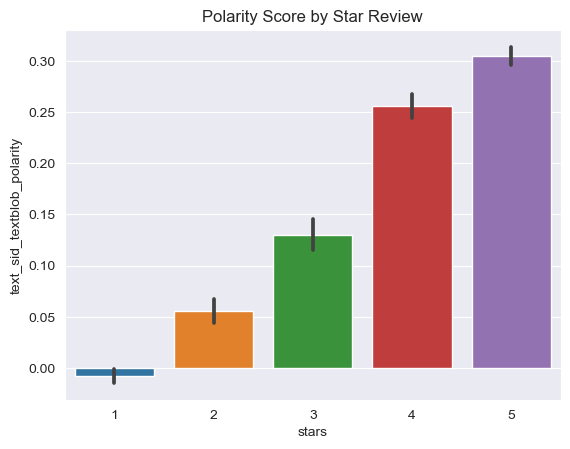

In [40]:
ax = sns.barplot(data=data, x='stars', y='text_sid_textblob_polarity')
ax.set_title('Polarity Score by Star Review')
plt.show()

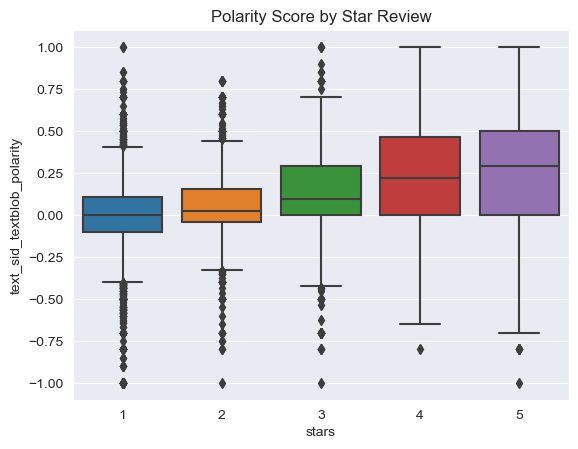

In [41]:
ax = sns.boxplot(data=data, x='stars', y='text_sid_textblob_polarity')
ax.set_title('Polarity Score by Star Review')
plt.show()

In [42]:
data.groupby('stars')['text_sid_textblob_polarity'].describe()

,count,mean,std,min,25%,50%,75%,max
stars,,,,,,,,
1,4518.0,-0.007768,0.229386,-1.0,-0.098795,0.000000,0.104256,1.0
2,1291.0,0.055340,0.223115,-1.0,-0.040455,0.025000,0.154419,0.8
3,1202.0,0.130262,0.271515,-1.0,0.000000,0.093809,0.288542,1.0
4,2025.0,0.256204,0.283480,-0.8,0.000000,0.220000,0.466667,1.0
5,4518.0,0.305047,0.291607,-1.0,0.000000,0.289394,0.500000,1.0


In [43]:
# Rating - sentiment analysis mapping
# 1 -1 - -.75
# 2 -.75 - .-25
# 3 -.25 - .25
# 4 .25 - .75
# 5 .75 - 1
# interpretation der daten
# abgrenzung der daten
# regressionsmodell zur abgrenzung

In [44]:
# data.to_csv('data_cleaned_apple.csv')

 ## Roberta Pretrained Model

In [45]:
# from transformers import AutoTokenizer
# from transformers import AutoModelForSequenceClassification
# from scipy.special import softmax

In [46]:
# MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
# tokenizer = AutoTokenizer.from_pretrained(MODEL)
# model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [47]:
# # encoded_text = tokenizer(data['text'][0], return_tensors='pt')
# # output = model(**encoded_text)
# # scores = output[0][0].detach().numpy()
# # scores = softmax(scores)
# # scores_dict = pd.Series(data=
# # {
# #     'roberta_neg': scores[0],
# #     'roberta_neu': scores[1],
# #     'roberta_pos': scores[2]
# # }
# # )
# # print(scores_dict)

In [48]:
# # sid_vader.polarity_scores(data['text'][0])

In [49]:
# def polarity_scores_roberta(text):
#     try:
#         encoded_text = tokenizer(text, return_tensors='pt')
#         output = model(**encoded_text)
#         scores = output[0][0].detach().numpy()
#         scores = softmax(scores)
#         scores_dict = {
#             'roberta_neg': scores[0],
#             'roberta_neu': scores[1],
#             'roberta_pos': scores[2]
#         }
#         return scores_dict
#
#     except RuntimeError:
#         # print(f'Broke for id {text}')
#         return np.nan

In [50]:
# dat_sub = data.groupby('stars').head(50)
# dat_sub['roberta'] = dat_sub['text_clean'].apply(lambda content: polarity_scores_roberta(content))
# dat_sub = pd.concat([
#     dat_sub.drop(['roberta'], axis=1),
#     dat_sub['roberta'].apply(lambda scores: pd.Series(data=
#     {
#         'roberta_neg': scores[0],
#         'roberta_neu': scores[1],
#         'roberta_pos': scores[2]
#     }))
# ], axis=1)
#

In [51]:
# fig, axs = plt.subplots(1, 3, figsize=(12, 3))
# sns.barplot(data=data, x='stars', y='roberta_neg', ax=axs[0])
# sns.barplot(data=data, x='stars', y='roberta_neu', ax=axs[1])
# sns.barplot(data=data, x='stars', y='roberta_pos', ax=axs[2])
# axs[0].set_title('Positive')
# axs[1].set_title('Neutral')
# axs[2].set_title('Negative')
# plt.tight_layout()
# plt.show()
# data.groupby('stars')['roberta_neg'].describe()
# data.groupby('stars')['roberta_neu'].describe()
# data.groupby('stars')['roberta_pos'].describe()
